In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import VarianceThreshold
import tensorflow as tf

from tensorflow.keras.layers import Dense, Flatten, Conv2D, LSTM
from tensorflow.keras import Model

In [3]:
j = 10
k = 10

features = pd.read_csv('daily_j' + str(j) + '_k' + str(k)+'_features.csv')
pct = pd.read_csv('daily_j' + str(j) + '_k' + str(k)+'_pct.csv')

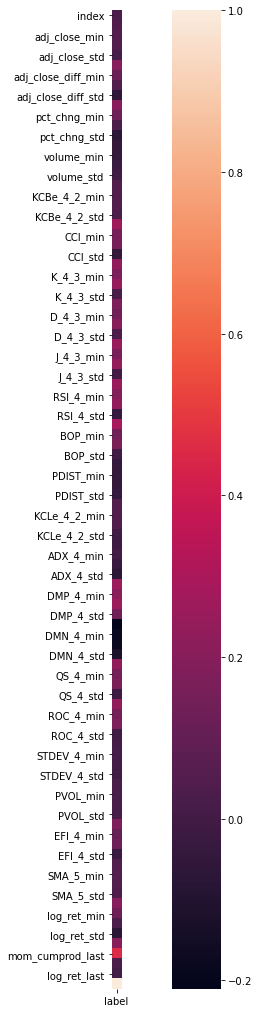

In [4]:
corr = features.corr() 
fig, ax = plt.subplots(figsize = (18, 18)) 
sns.heatmap(corr[['label']], square=True) 

In [5]:
correlated_features = set()
for i in range(len(corr.columns)):
    for a in range(i):
        if abs(corr.iloc[i, a]) > 0.90:
            colname = corr.columns[i]
            correlated_features.add(colname)

In [6]:
num_colums = ['uint8','int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerical_columns = list(features.select_dtypes(include=num_colums).columns)
df = features[numerical_columns]
df

,index,adj_close_mean,adj_close_min,adj_close_max,adj_close_std,adj_close_diff_mean,adj_close_diff_min,adj_close_diff_max,adj_close_diff_std,pct_chng_mean,...,SMA_5_std,log_ret_mean,log_ret_min,log_ret_max,log_ret_std,cumprod_last,mom_cumprod_last,rev_cumprod_last,log_ret_last,label
0,0,1136.777327,1091.760010,1150.229980,15.081346,-2.944999,-24.719971,14.199951,11.504507,-0.002423,...,4.731755,-0.002471,-0.022390,0.012422,0.009865,-0.036390,0.243343,-0.159836,-0.022390,1.0
1,1,1091.051426,1073.869995,1103.319946,9.724233,1.089986,-12.969971,15.319946,12.318654,0.000896,...,0.673109,0.000849,-0.011888,0.014165,0.010345,0.005963,0.007389,0.018856,0.012890,0.0
2,2,1074.803331,1056.739990,1097.280029,14.249722,-2.721252,-34.170044,13.780029,14.728086,-0.002151,...,4.365267,-0.002227,-0.031636,0.012956,0.012831,-0.019840,-0.043279,-0.025423,-0.002748,0.0
3,3,1103.662012,1094.869995,1109.170044,6.191079,3.285004,-1.160034,7.239990,3.558300,0.002393,...,0.000000,0.002386,-0.001046,0.006563,0.003097,0.012001,0.000000,0.000000,-0.001046,0.0
4,4,1108.627767,1094.599976,1122.969971,10.650013,3.546249,-2.300049,11.219971,4.937411,0.002855,...,6.100350,0.002843,-0.002083,0.010107,0.004313,0.025918,-0.021017,-0.008854,0.003729,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
402,402,3840.132031,3798.909912,3855.360107,23.651921,14.112549,-11.600098,52.940186,27.898588,0.002972,...,0.000000,0.002950,-0.003015,0.013839,0.006524,0.014860,0.044117,-0.011486,0.003609,1.0
403,403,3805.967801,3714.239990,3871.739990,52.409185,2.764984,-98.850098,59.620117,59.098503,0.000731,...,9.553497,0.000637,-0.026013,0.015924,0.014617,0.005746,-0.017804,-0.004672,0.010795,0.0
404,404,3908.795724,3886.830078,3934.830078,17.095568,8.000000,-4.360107,28.760010,13.012541,0.001759,...,5.915260,0.001753,-0.001114,0.007372,0.003137,0.012349,0.063108,0.054149,0.004700,1.0
405,405,3909.700021,3876.500000,3932.590088,22.990007,-1.193359,-30.209961,44.059814,25.395870,-0.000245,...,5.297419,-0.000260,-0.007763,0.011288,0.005943,-0.001821,0.022329,-0.033275,0.011288,1.0


In [7]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(df.drop('label',axis=1), 
                                                    df['label'], train_size=0.33)
X_before = X_test


X_train.drop(columns=correlated_features, axis=1, inplace=True)
X_test.drop(columns=correlated_features, axis=1, inplace=True)


scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [15]:
X_train.shape

(134, 53)

In [40]:
X_train = X_train.reshape(-1, 5, X_train.shape[1])
X_test  = X_test.reshape(-1, 5, X_train.shape[1])
y_train = y_train.reshape(-1, 5, y_train.shape[0])
y_test = y_test.reshape(-1, 5, y_test.shape[0])

ValueError: cannot reshape array of size 7102 into shape (5,53)

In [37]:
n_timesteps, n_features, n_outputs = X_train.shape[0], X_train.shape[1], y_train.shape[0]

In [38]:
model = tf.keras.Sequential()
model.add(LSTM(100, input_shape=(n_timesteps,n_features)))
model.add(tf.keras.layers.Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [39]:
verbose, epochs, batch_size = 0, 15, 64
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)
_, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)

ValueError: in user code:

    /home/auqdah/.local/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /home/auqdah/.local/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/auqdah/.local/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/auqdah/.local/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/auqdah/.local/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/auqdah/.local/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:788 run_step  **
        outputs = model.train_step(data)
    /home/auqdah/.local/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:754 train_step
        y_pred = self(x, training=True)
    /home/auqdah/.local/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /home/auqdah/.local/lib/python3.7/site-packages/tensorflow/python/keras/engine/input_spec.py:223 assert_input_compatibility
        str(tuple(shape)))

    ValueError: Input 0 of layer sequential_2 is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 53)
